# Model comparison
## Meta pretrain model vs models train on different datasets

#### Meta model was train on the 1M recipe dataset
#### Custom models were train on Kaggle Food Ingredients and Recipes Dataset with Images
https://www.kaggle.com/datasets/pes12017000148/food-ingredients-and-recipe-dataset-with-images?select=Food+Images

#### Configure drive and import libraries

The notebook is run on colab, the following command will mount the project folder

In [1]:
from google.colab import drive
drive.mount("/content/drive")
# cd to a folder in your Drive - in my case is this route
%cd '/content/drive/Othercomputers/Mi portátil/gastroml/src'

Mounted at /content/drive
/content/drive/Othercomputers/Mi portátil/gastroml/src


In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import os
from args import get_parser
import pickle
from model import get_model
from torchvision import transforms
from utils.output_utils import prepare_output
from PIL import Image
import time
from build_vocab import Vocabulary

%load_ext autoreload
%autoreload 2

In [3]:
# code will run in gpu if available and if the flag is set to True, else it will run on cpu
use_gpu = False
device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
map_loc = None if torch.cuda.is_available() and use_gpu else 'cpu'

# Model and vocab definitions and paths

### Constants definitions

In [4]:
params_dict = {}
model_list = ["model", "modeResnet18", "modeResnet101", "modelResnet152", "modelMeta"]
model_dict = {"model":"Resnet50", "modeResnet18":"Resnet18", "modeResnet101":"Resnet101", "modelResnet152":"Resnet152","modelMeta":"Meta"}
model_dir = "../checkpoints/inversecooking"
data_dir = '../data'
vocab_ings_dict = {"model":"recipe1m_vocab_ingrs", "modeResnet18":"recipe1m_vocab_ingrs", "modeResnet101":"recipe1m_vocab_ingrs", "modelResnet152":"recipe1m_vocab_ingrs","modelMeta":"ingr_vocab_meta"}
vocab_inst_dict = {"model":"recipe1m_vocab_toks", "modeResnet18":"recipe1m_vocab_toks", "modeResnet101":"recipe1m_vocab_toks", "modelResnet152":"recipe1m_vocab_toks","modelMeta":"instr_vocab_meta"}

In [5]:
train_image_folder = os.path.join("../Kaggle data/images", 'train')
test_image_folder = os.path.join("../Kaggle data/images", 'test')
val_image_folder = os.path.join("../Kaggle data/images", 'val')
demo_image_folder = os.path.join("../data", 'demo_imgs')


train_imgs = os.listdir(train_image_folder)
test_imgs = os.listdir(test_image_folder)
val_imgs = os.listdir(val_image_folder)
demo_imgs = os.listdir(demo_image_folder)

In [6]:
len(val_imgs)

1978

In [7]:
len(demo_imgs)

6

### Functions to get vocab, load_model based on model name

In [8]:
def get_vocab_pickle(model_name):
    """Function to get the vocab pickle file for a given model name.
    If the model name is "modelMeta", the function will return the meta vocab pickle files.
    The meta vocab pickle files are pretrained and were downloaded from the original repo.
    url: https://github.com/facebookresearch/inversecooking
    If the model name is "model", the function will return the recipe1m vocab pickle files.
    The vocab files were created using the build_vocab.py script with the kaggle dataset.

    Args:
        model_name (str): Model name. It can be "model", "modelMeta", "modeResnet18", "modeResnet101", "modelResnet152"

    Returns:
        vocab, ingrs_vocab, ingr_vocab_size, instrs_vocab_size, output_dim: vocab pickle files and vocab sizes
    """
    vocab_ing_name = vocab_ings_dict[model_name]
    vocab_inst_name = vocab_inst_dict[model_name]
    if model_name != "modelMeta":
        ing_vocab_name = "ingr_vocab"
        vocab_name = "instr_vocab"
        ingrs_vocab = pickle.load(open(os.path.join(data_dir, f'{vocab_ing_name}.pkl'), 'rb'))
        ingrs_vocab = [min(w, key=len) if not isinstance(w, str) else w for w in ingrs_vocab.idx2word.values()]
        vocab = pickle.load(open(os.path.join(data_dir, f'{vocab_inst_name}.pkl'), 'rb')).idx2word

    else:
        ing_vocab_name = "ingr_vocab_meta"
        vocab_name = "instr_vocab_meta"
        ingrs_vocab = pickle.load(open(os.path.join(data_dir, 'ingr_vocab_meta.pkl'), 'rb'))
        vocab = pickle.load(open(os.path.join(data_dir, 'instr_vocab_meta.pkl'), 'rb'))

    pickle.dump(ingrs_vocab, open(f'../data/f{ing_vocab_name}.pkl', 'wb'))
    pickle.dump(vocab, open(f'../data/f{vocab_name}.pkl', 'wb'))

    ingr_vocab_size = len(ingrs_vocab)
    instrs_vocab_size = len(vocab)
    output_dim = instrs_vocab_size
    return vocab, ingrs_vocab, ingr_vocab_size, instrs_vocab_size, output_dim

In [9]:
# for model_name in model_list:
#     print(model_name)
#     vocab, ingrs_vocab, ingr_vocab_size, instrs_vocab_size, output_dim = get_vocab_pickle(model_name)
#     print(ingr_vocab_size, instrs_vocab_size, output_dim)

In [10]:
import sys; sys.argv=['']; del sys
def load_model(model_name, model_dir, map_loc):
    """Function to load a model given a model name, a model directory and a map location.
    The map location is the device where the model will be loaded.
    The model directory is the directory where the model is stored.
    The model name is the name of the model to be loaded.
    The meta model is the model trained with the meta vocab pickle files and
    downloaded from the original repo. This model was trained with the original dataset.

    Args:
        model_name (str): Model name. It can be "model", "modelMeta", "modeResnet18", "modeResnet101", "modelResnet152"
        model_dir (str): Folder where the model is stored.
        map_loc (str): Device where the model will be loaded. It can be "cpu" or "cuda"

    Returns:
        _type_: _description_
    """
    # print(model_name)
    vocab, ingrs_vocab, ingr_vocab_size, instrs_vocab_size, output_dim = get_vocab_pickle(model_name)
    args = get_parser()
    args.maxseqlen = 15
    args.ingrs_only=False
    # if metal model, use default arguments for image model
    if model_name != "modelMeta":
        args.image_model = model_dict[model_name].lower()
    model = get_model(args, ingr_vocab_size, instrs_vocab_size)
    model_path = os.path.join(model_dir, model_name+'/checkpoints/modelbest.ckpt')
    # print(model_path)
    model.load_state_dict(torch.load(model_path, map_location=map_loc))
    model.to(device)
    model.eval()
    model.ingrs_only = False
    model.recipe_only = False

    return model, vocab, ingrs_vocab, ingr_vocab_size, instrs_vocab_size, output_dim

In [32]:
def get_n_params(model):
    pp=0
    for p in list(model[0].parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [34]:
for model_name in model_list:
    print(model_name)
    model = load_model(model_name, model_dir, map_loc)
    params_num = get_n_params(model)
    print(params_num)


model


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


81356110
modeResnet18


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


68238158
modeResnet101


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


100348238
modelResnet152


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


115991886
modelMeta
103779021


### get predictions on the datasets

In [35]:
transf_list_batch = []
transf_list_batch.append(transforms.ToTensor())
transf_list_batch.append(transforms.Normalize((0.485, 0.456, 0.406),
                                              (0.229, 0.224, 0.225)))
to_input_transf = transforms.Compose(transf_list_batch)

greedy = True
beam =-1
temperature = 1.0
numgens = 1



In [36]:
def generate_predictions(model_name,dataset,model_dir, map_loc):
    """Function to generate predictions given a model name and a dataset.
    The model name is the name of the model to be loaded.
    The dataset is the dataset to be used to generate the predictions.
    The function will return a list of lists with the following structure:
    [dataset, model_name, img_file, greedy,beam, outs['title'], outs['ingrs'], outs['recipe']]
    The list of lists will contain the dataset name, the model name, the image file name,
    the greedy flag, the beam size, the title, the ingredients and the recipe.

    Args:
        model_name (str): Model name. It can be "model", "modelMeta", "modeResnet18", "modeResnet101", "modelResnet152"
        dataset (str): Dataset to be used. It can be "train", "test" or "val"
    """
    t = time.time()
    if dataset == "train":
        set_imgs = train_imgs
        image_folder = train_image_folder
    elif dataset == "test":
        set_imgs = test_imgs
        image_folder = test_image_folder
    elif dataset == "val":
        set_imgs = val_imgs
        image_folder = val_image_folder
    elif dataset == "demo":
        set_imgs = demo_imgs
        image_folder = demo_image_folder
    else:
        print("Dataset not valid")
        return None

    model, vocab, ingrs_vocab, ingr_vocab_size, instrs_vocab_size, output_dim = load_model(model_name, model_dir, map_loc)
    predictions = []
    for img_num, img_file in enumerate(set_imgs):
        image_path = os.path.join(image_folder, img_file)
        image = Image.open(image_path).convert('RGB')

        transf_list = []
        transf_list.append(transforms.Resize(256))
        transf_list.append(transforms.CenterCrop(224))
        transform = transforms.Compose(transf_list)

        image_transf = transform(image)
        image_tensor = to_input_transf(image_transf).unsqueeze(0).to(device)
        # plt.imshow(image_transf)
        # plt.axis('off')
        # plt.show()
        # plt.close()

        pred_valid = False
        counter_not_valid = 0

        while not pred_valid:
            with torch.no_grad():
                outputs = model.sample(image_tensor, greedy=greedy,
                                    temperature=temperature, beam=beam, true_ingrs=None)

            ingr_ids = outputs['ingr_ids'].cpu().numpy()
            recipe_ids = outputs['recipe_ids'].cpu().numpy()

            outs, valid = prepare_output(recipe_ids[0], ingr_ids[0], ingrs_vocab, vocab)
            # check if output is valid, if not try again until a valid output is found
            # or try again 5 times and then return the last valid output
            if valid['is_valid'] or counter_not_valid < 5:

                predictions.append([dataset, model_name, model_dict[model_name], img_file, greedy,beam, outs['title'], outs['ingrs'], outs['recipe']])

                pred_valid=True

            else:
                pass
                print ("Not a valid recipe!")
                print ("Reason: ", valid['reason'])
                print( outs['title'], outs['ingrs'])
                counter_not_valid += 1
        if img_num % 100 == 0 and img_num >0:
            print(img_num)
            print("Elapsed time:", time.time() -t)
            columns = ['dataset', 'model_name', 'conv_model', 'img_file', 'greedy','beam', 'title', 'ingrs', 'recipe']
            back_up_predictions = pd.DataFrame(predictions, columns=columns)
            back_up_predictions.to_csv(f'../data/predictions/{dataset}_{model_name}_{img_num}.csv', index=False)

    return predictions

In [37]:

demo_predictions = {}
for dataset in ["demo"]:
    print(dataset)
    for model_name in model_list:
        print(model_name)
        predictions = generate_predictions(model_name,dataset,model_dir, map_loc)
        columns = ['dataset', 'model_name', 'conv_model', 'img_file', 'greedy','beam', 'title', 'ingrs', 'recipe']
        predictions = pd.DataFrame(predictions, columns=columns)
        predictions.to_csv(f'../data/predictions/{dataset}_{model_name}.csv', index=False)
        demo_predictions[model_name] = predictions

demo
model
modeResnet18


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


modeResnet101


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


modelResnet152


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


modelMeta


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [38]:
demo_predictions_df = pd.concat(demo_predictions).reset_index()

In [39]:
for model in demo_predictions_df["level_0"].unique():
  print(model)
  dp = demo_predictions_df[demo_predictions_df["level_0"] == model]
  for x in dp.to_dict("records"):
    print(x["img_file"])
    print(x["title"])
    print(str(x["ingrs"]).replace("'",""))
    print(x["recipe"])

model
1.jpg
Grilled red onion salad
[oil, salt, pepper, garlic, onion, olive, vinegar, juice, lemon]
['Heat the olive oil in a large skillet over medium heat. add the onion and cook for 5 minutes, stirring occasionally, until the garlic is fragrant, about 5 minutes. add the garlic and cook for 5 minutes, stirring occasionally, until the garlic is fragrant, about 5 minutes. add the garlic and cook for 10 minutes, stirring occasionally, until the onion is absorbed, about 5 minutes. add the olive oil and cook for 5 minutes. add the onion and cook for 5 minutes, stirring occasionally, until the pasta is absorbed, about 5 minutes. add the pasta and cook for 5 minutes. add the pasta and cook for 5 minutes, stirring occasionally, until the pasta is absorbed, about 5 minutes. add the pasta and']
2.jpg
Spiced fried eggs
[salt, oil, sugar, pepper, garlic, egg, flour]
['Preheat oven to 350â°f. line a rimmed baking sheet with parchment paper.', 'Whisk flour, salt, and pepper in a medium bowl. whis

In [40]:
predictions_folder = os.path.join("../data", 'predictions')
predictions_backup_files = os.listdir(predictions_folder)

In [41]:

test_predictions = {}
for dataset in ["test"]:#,"val","train"]:
    print(dataset)
    for model_name in model_list:
        try:
          test_predictions[model_name] = pd.read_csv(f'../data/predictions/{dataset}_{model_name}.csv')
          print(f"Backup found {model_name}")
          print(test_predictions[model_name].shape[0], dataset)
        except:
          print(f"Backup not found {model_name}")
          predictions = generate_predictions(model_name,dataset,model_dir, map_loc)
          columns = ['dataset', 'model_name', 'conv_model', 'img_file', 'greedy','beam', 'title', 'ingrs', 'recipe']
          predictions = pd.DataFrame(predictions, columns=columns)
          predictions.to_csv(f'../data/predictions/{dataset}_{model_name}.csv', index=False)
          test_predictions[model_name] = predictions

test
Backup found model
2010 test
Backup found modeResnet18
2010 test
Backup found modeResnet101
2010 test
Backup found modelResnet152
2010 test
Backup found modelMeta
2010 test


In [42]:
test_predictions_df = pd.concat(test_predictions)
test_predictions_df = test_predictions_df.dropna(axis=1)
test_predictions_df = test_predictions_df.reset_index()

In [43]:
test_predictions_df.head(2)

,level_0,level_1,dataset,model_name,conv_model,img_file,greedy,beam,title,ingrs,recipe
0,model,0,test,model,Resnet50,basic-duck-stock-51197610.jpg,True,-1,Spicy soup,"['salt', 'oil', 'pepper', 'garlic', 'onion', '...",['Heat oil in a large skillet over medium-high...
1,model,1,test,model,Resnet50,goose-stew-with-barley-and-celery-root-5119763...,True,-1,Spicy tomato soup,"['oil', 'salt', 'pepper', 'garlic', 'onion', '...",['Heat oil in a large pot over medium-high. ad...


### Create metrics

In [44]:
!pip install -U sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 21.3 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=9e8e67dc0c39afdb60a14edd6aac5dc6acddda765e23c4aef19c4b08abb9f44b
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [45]:
from ast import literal_eval

# beging code taken from https://www.geeksforgeeks.org/how-to-calculate-jaccard-similarity-in-python/
def jaccard_similarity(list1, list2):
    # intersection of two sets
    set1 = set(list1)
    set2 = set(list2)
    intersection = len(set1.intersection(set2))
    # Unions of two sets
    union = len(set1.union(set2))

    return intersection / union



def jaccard_distance(list1, list2):
    #Symmetric difference of two sets
    set1 = set(list1)
    set2 = set(list2)
    Symmetric_difference = set1.symmetric_difference(set2)
    # Unions of two sets
    union = set1.union(set2)

    return len(Symmetric_difference)/len(union)
# end code taken from https://www.geeksforgeeks.org/how-to-calculate-jaccard-similarity-in-python/

In [46]:
from sentence_transformers import SentenceTransformer, util
simmodel = SentenceTransformer('all-MiniLM-L6-v2')

def simscore(str1, str2):
    em1 = simmodel.encode(str1, convert_to_tensor=True)
    em2 = simmodel.encode(str2, convert_to_tensor=True)

    return util.cos_sim(em1, em2).item()

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

In [47]:
## get actual recipe names
import pandas as pd
recipe_names = pd.read_csv('../Kaggle data/final_data.csv')
recipe_names["image_name"] = recipe_names["image_name"]+".jpg"

recipe_names["ingredients_rawmats"] = recipe_names["ingredients_rawmats"].apply(literal_eval)
#recipe_names["recipe"] = recipe_names["recipe"].apply(literal_eval)
recipe_names.head()

,id,title,ingredients,instructions,image_name,cleaned_ingredients,ingredients_rawmats,partition
0,0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"['1 (3Â½â€“4-lb.) whole chicken', '2Â¾ tsp. ko...","Pat chicken dry with paper towels, season all ...",miso-butter-roast-chicken-acorn-squash-panzane...,"['1 (3Â½â€“4-lb.) whole chicken', '2Â¾ tsp. ko...","[squash, oil, apples, onion, bread, apple, flo...",train
1,1,Crispy Salt and Pepper Potatoes,"['2 large egg whites', '1 pound new potatoes (...",Preheat oven to 400Â°F and line a rimmed bakin...,crispy-salt-and-pepper-potatoes-dan-kluger.jpg,"['2 large egg whites', '1 pound new potatoes (...","[pepper, salt, egg, potatoes]",train
2,2,Thanksgiving Mac and Cheese,"['1 cup evaporated milk', '1 cup whole milk', ...",Place a rack in middle of oven; preheat to 400...,thanksgiving-mac-and-cheese-erick-williams.jpg,"['1 cup evaporated milk', '1 cup whole milk', ...","[onion, garlic, pepper, cheese, cheddar, papri...",train
3,3,Italian Sausage and Bread Stuffing,"['1 (Â¾- to 1-pound) round Italian loaf, cut i...",Preheat oven to 350Â°F with rack in middle. Ge...,italian-sausage-and-bread-stuffing-240559.jpg,"['1 (Â¾- to 1-pound) round Italian loaf, cut i...","[oil, garlic, turkey, butter, eggs, stock, sau...",train
4,4,Newton's Law,"['1 teaspoon dark brown sugar', '1 teaspoon ho...",Stir together brown sugar and hot water in a c...,newtons-law-apple-bourbon-cocktail.jpg,"['1 teaspoon dark brown sugar', '1 teaspoon ho...","[cinnamon, bourbon, apple, juice, butter, wate...",train


In [48]:
# get predictions
pred_df = test_predictions_df.copy()

pred_df["ingrs"] = pred_df["ingrs"].apply(literal_eval)
pred_df["recipe"] = pred_df["recipe"].apply(literal_eval)
pred_df.head(2)

,level_0,level_1,dataset,model_name,conv_model,img_file,greedy,beam,title,ingrs,recipe
0,model,0,test,model,Resnet50,basic-duck-stock-51197610.jpg,True,-1,Spicy soup,"[salt, oil, pepper, garlic, onion, broth, seed...",[Heat oil in a large skillet over medium-high....
1,model,1,test,model,Resnet50,goose-stew-with-barley-and-celery-root-5119763...,True,-1,Spicy tomato soup,"[oil, salt, pepper, garlic, onion, tomato, car...",[Heat oil in a large pot over medium-high. add...


## Title and Ingredients similarity


In [49]:
# join dataframes, real and predictions
pred_df = pd.merge(
    pred_df,
    recipe_names,
    left_on="img_file",
    right_on="image_name",
    how="left",
    suffixes=("_pred", "_true")
    )

In [50]:
# get title similarity score
pred_df["title_simscore"] = [simscore(actual_title, pred_title) for actual_title, pred_title in zip(pred_df["title_true"], pred_df["title_pred"])]

In [51]:
pred_df["ingr_num_pred"] = [len(ingrs) for ingrs in pred_df["ingrs"]]
pred_df["ingr_num_true"] = [len(ingrs) for ingrs in pred_df["ingredients_rawmats"]]

pred_df["ingr_jaccard"] = [jaccard_similarity(ingrs_true, ingrs_pred) for ingrs_true, ingrs_pred in zip(pred_df["ingredients_rawmats"], pred_df["ingrs"])]
pred_df["ingr_jaccard_dist"] = [jaccard_distance(ingrs_true, ingrs_pred) for ingrs_true, ingrs_pred in zip(pred_df["ingredients_rawmats"], pred_df["ingrs"])]

In [52]:
pred_df["ingr_num_diff"] = pred_df["ingr_num_true"] - pred_df["ingr_num_pred"]

In [53]:
def array_to_string(array, delimiter=" "):
    return delimiter.join(array)

In [54]:
pred_df["ings_simscore"] = [simscore(array_to_string(np.sort(x)),array_to_string(np.sort(y))) for x,y in zip(pred_df["ingredients_rawmats"], pred_df["ingrs"])]

In [55]:
pred_df.to_csv("../data/predictions/test_predictions.csv")

In [56]:
pred_df = pd.read_csv("../data/predictions/test_predictions.csv")
pred_df.head(2)

,Unnamed: 0,level_0,level_1,dataset,model_name,conv_model,img_file,greedy,beam,title_pred,...,cleaned_ingredients,ingredients_rawmats,partition,title_simscore,ingr_num_pred,ingr_num_true,ingr_jaccard,ingr_jaccard_dist,ingr_num_diff,ings_simscore
0,0,model,0,test,model,Resnet50,basic-duck-stock-51197610.jpg,True,-1,Spicy soup,...,"['Carcasses of 4 to 6 wild ducks, 2 to 3 wild ...","['from', 'salt', 'garlic', 'carcasses', 'possi...",test,0.163386,9,19,0.166667,0.833333,10,0.427052
1,1,model,1,test,model,Resnet50,goose-stew-with-barley-and-celery-root-5119763...,True,-1,Spicy tomato soup,...,"['8 goose legs (2 to 3 pounds)', '3 tablespoon...","['fat', 'onion', 'sour', 'root', 'legs', 'pepp...",test,0.245502,12,17,0.115385,0.884615,5,0.557043


In [57]:
pred_df["conv_model"].unique()

array(['Resnet50', 'Resnet18', 'Resnet101', 'Resnet152', 'Meta'],
      dtype=object)

In [58]:
pred_df_pv = pred_df.pivot_table(index="title_true",columns="model_name",values=["title_simscore","ingr_num_pred","ingr_num_true",	"ingr_jaccard",	"ingr_jaccard_dist","ingr_num_diff","ings_simscore"],aggfunc="mean")

In [59]:
pred_df_pv2 =pred_df.pivot_table(index="title_true",columns="model_name",values=["title_pred","ingrs","ingredients_rawmats"],aggfunc=pd.Series.mode)

In [60]:
pred_df_pv = pd.merge(
    pred_df_pv,
    pred_df_pv2,
    left_index=True,
    right_index=True,
    how="left"
)

pred_df_pv.to_csv("../data/predictions/test_predictions_pivot.csv",sep=";")

In [79]:
pred_df[["model_name","title_simscore","ings_simscore","ingr_jaccard","ingr_num_diff",	"ingr_num_pred",	"ingr_num_true",]].groupby("model_name").mean().round(3)

,title_simscore,ings_simscore,ingr_jaccard,ingr_num_diff,ingr_num_pred,ingr_num_true
model_name,,,,,,
modeResnet101,0.317,0.536,0.196,3.982,8.318,12.3
modeResnet18,0.312,0.542,0.195,3.400,8.900,12.3
model,0.325,0.544,0.200,3.299,9.001,12.3
modelMeta,0.398,0.535,0.166,6.145,6.155,12.3
modelResnet152,0.320,0.558,0.197,2.585,9.715,12.3


In [80]:
pred_df[["model_name","title_simscore","ings_simscore","ingr_jaccard","ingr_num_diff",	"ingr_num_pred",	"ingr_num_true",]].groupby("model_name").std().round(3)

,title_simscore,ings_simscore,ingr_jaccard,ingr_num_diff,ingr_num_pred,ingr_num_true
model_name,,,,,,
modeResnet101,0.135,0.133,0.111,5.817,1.517,5.826
modeResnet18,0.132,0.136,0.112,5.722,1.774,5.826
model,0.135,0.133,0.109,5.752,1.571,5.826
modelMeta,0.179,0.142,0.116,5.858,2.097,5.826
modelResnet152,0.137,0.137,0.111,5.734,2.172,5.826


In [62]:
pred_df[["model_name","title_simscore","ings_simscore","ingr_jaccard","ingr_num_diff",	"ingr_num_pred",	"ingr_num_true",]].groupby("model_name").median()

,title_simscore,ings_simscore,ingr_jaccard,ingr_num_diff,ingr_num_pred,ingr_num_true
model_name,,,,,,
modeResnet101,0.303835,0.548215,0.190476,3.0,8.0,12.0
modeResnet18,0.295012,0.552750,0.187500,3.0,9.0,12.0
model,0.310224,0.555906,0.192308,3.0,9.0,12.0
modelMeta,0.374721,0.549478,0.150000,5.0,6.0,12.0
modelResnet152,0.301073,0.574678,0.187500,2.0,10.0,12.0


In [63]:
import seaborn as sns

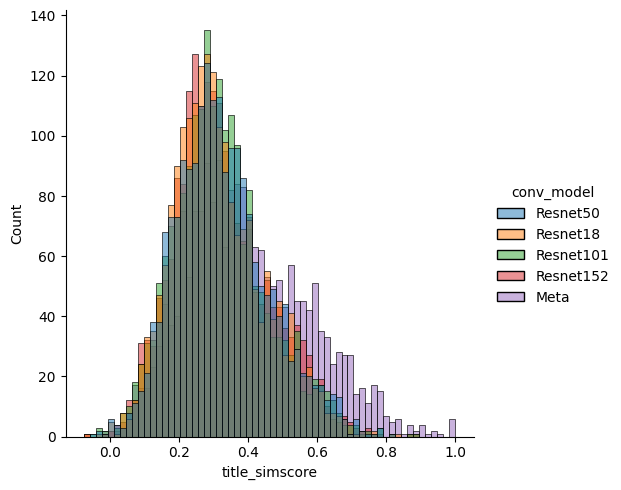

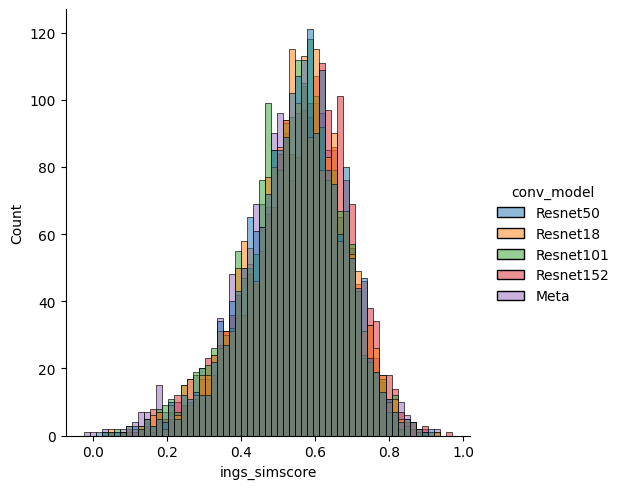

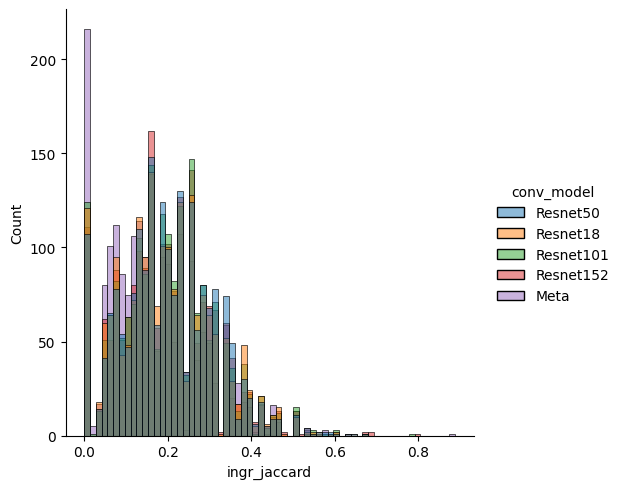

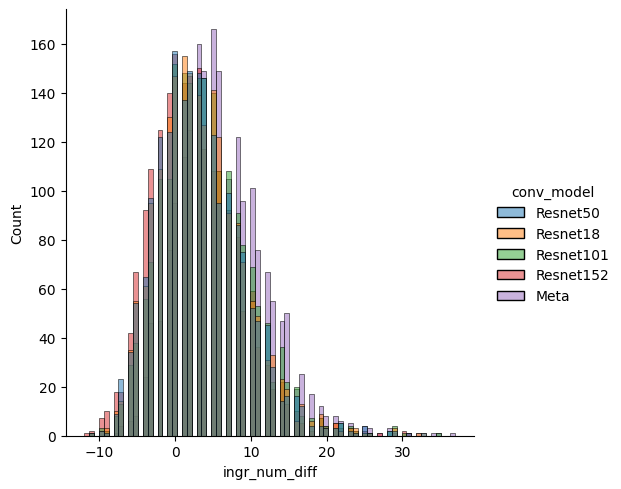

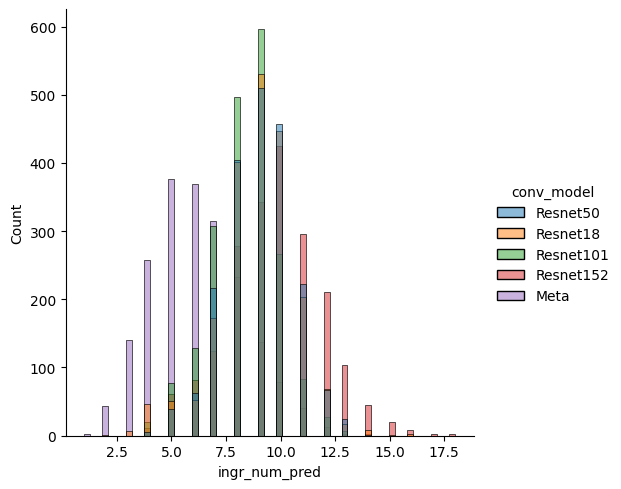

In [64]:
for col in ["title_simscore","ings_simscore","ingr_jaccard","ingr_num_diff",	"ingr_num_pred",]:
  sns.displot(pred_df,x=col,hue="conv_model")
  plt.show()

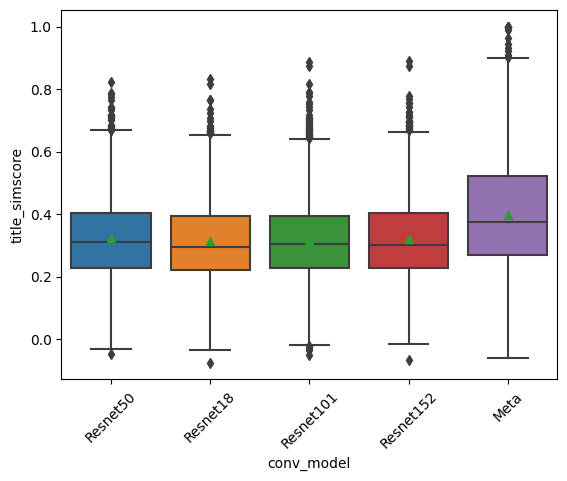

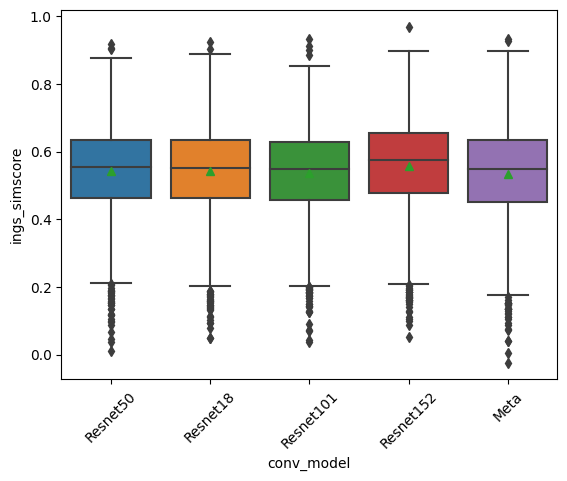

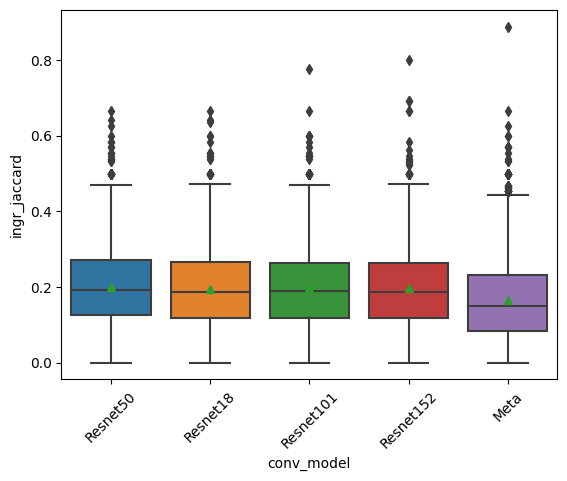

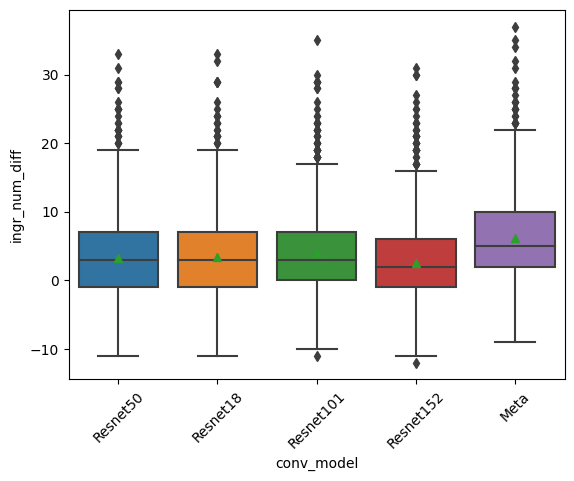

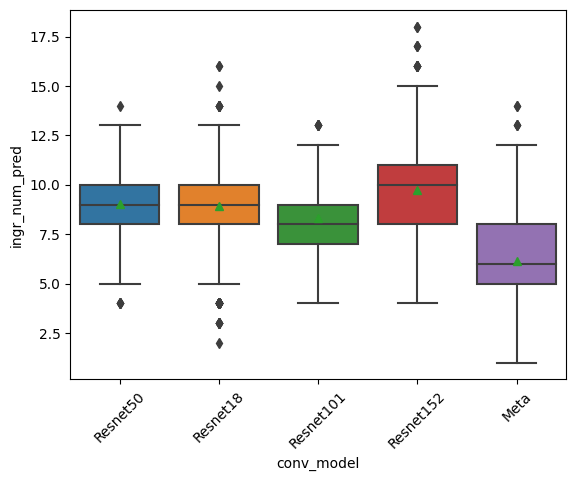

In [65]:
for col in ["title_simscore","ings_simscore","ingr_jaccard","ingr_num_diff",	"ingr_num_pred",]:
  sns.boxplot(pred_df,y=col,x="conv_model", showmeans=True)
  plt.xticks(rotation=45)
  plt.show()

In [86]:
pred_df_ing_true = pred_df.groupby(["conv_model","ingr_num_true"]).mean().reset_index()

<ipython-input-86-8d34dd1d9c03>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  pred_df_ing_true = pred_df.groupby(["conv_model","ingr_num_true"]).mean().reset_index()


Text(0, 0.5, 'Number of predicted ingridients (#)')

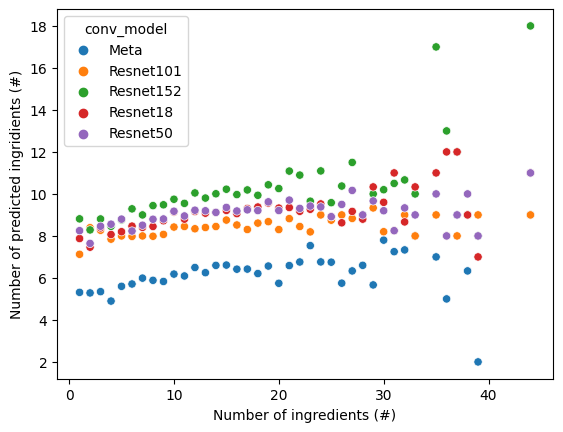

In [95]:
sns.scatterplot(pred_df_ing_true,x="ingr_num_true",y="ingr_num_pred",hue="conv_model")
#plt.set(xlabel='Number of ingredients (#)', ylabel='Number of predicted ingridients (#)')
plt.xlabel('Number of ingredients (#)')
plt.ylabel('Number of predicted ingridients (#)')

# word cloud generation

In [66]:
from wordcloud import WordCloud

In [67]:
pred_df_wordcloud = pred_df[['model_name',
       'conv_model', 'title_pred','title_true', 'ingrs',
       'ingredients_rawmats']]

### wordcloud for titles

#### True dish titles

In [68]:
!ls

 args.py				   modules
 build_vocab.py				   my_checkpoint.pth.tar
 data_loader.py				   __pycache__
 demo.ipynb				   runs
 demo_steve.ipynb			   sample.py
'gastroML - ImageCaptioning.ipynb'	   test_greedy_gencaps.pkl
 gastroML-train.ipynb			   test_modeResnet18.csv
'gastroML-train -Test conv models.ipynb'   train.py
'model_comparison copy.ipynb'		   utils
 model_comparison.ipynb			   utils_imgTocap.py
 model.py


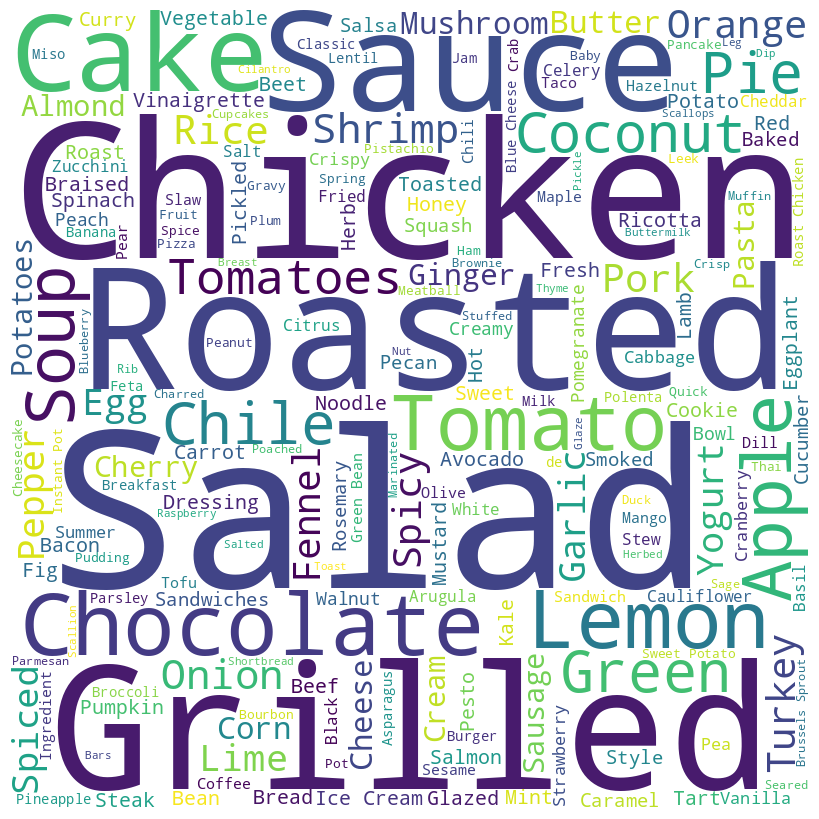

In [69]:
text_title_true = ' '.join(pred_df_wordcloud[pred_df_wordcloud["conv_model"]=="Meta"]["title_true"])
wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(text_title_true)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('../Kaggle data/true_title_wordcloud.png')
# Mostrar la nube de palabras
plt.show()

In [70]:
for model in pred_df_wordcloud["conv_model"].unique():
  text_title_true = ' '.join(pred_df_wordcloud[pred_df_wordcloud["conv_model"]==model]["title_true"])
  wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(text_title_true)
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  print("*"*50)
  print(f"Model: {model}")

  plt.savefig(f'../Kaggle data/predicted_title_wordcloud_{model}.png')
  # Mostrar la nube de palabras
  plt.show()
  print("*"*50)

Output hidden; open in https://colab.research.google.com to view.

### Wordcloud ingridients

In [71]:
pred_df_wordcloud.head(1)

,model_name,conv_model,title_pred,title_true,ingrs,ingredients_rawmats
0,model,Resnet50,Spicy soup,Basic Duck Stock,"['salt', 'oil', 'pepper', 'garlic', 'onion', '...","['from', 'salt', 'garlic', 'carcasses', 'possi..."


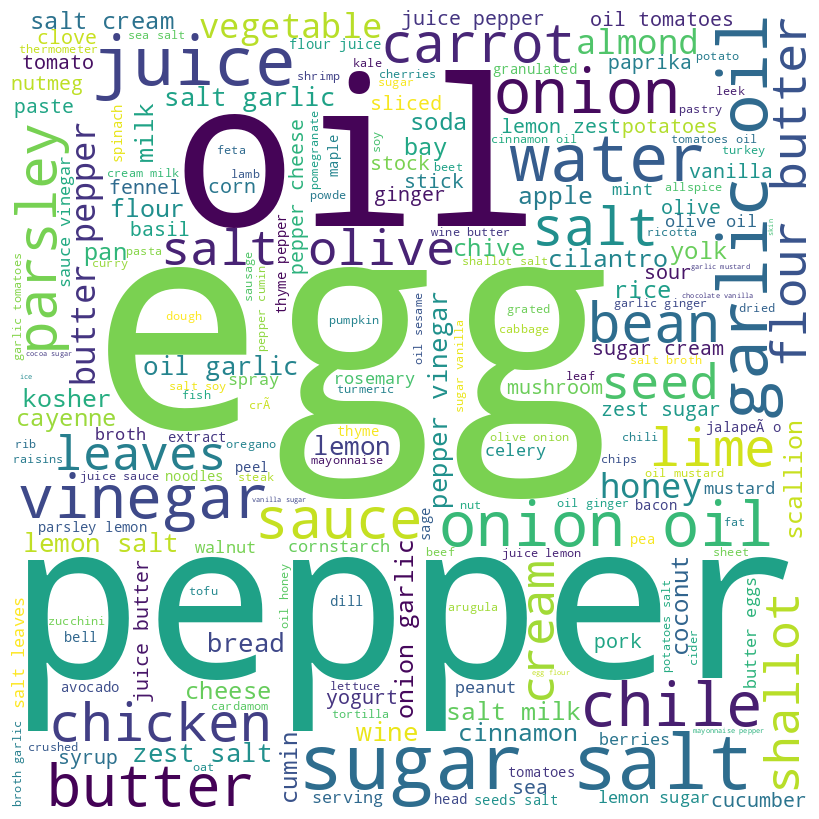

In [72]:
text_title_true = ' '.join(pred_df_wordcloud[pred_df_wordcloud["conv_model"]=="Meta"]["ingredients_rawmats"])
text_title_true = text_title_true.replace("'","").replace(",","").replace("_"," ").replace("  "," ")
wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(text_title_true)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.savefig('../Kaggle data/true_ingrs_wordcloud.png')
# Mostrar la nube de palabras
plt.show()

**************************************************
Model: Resnet50


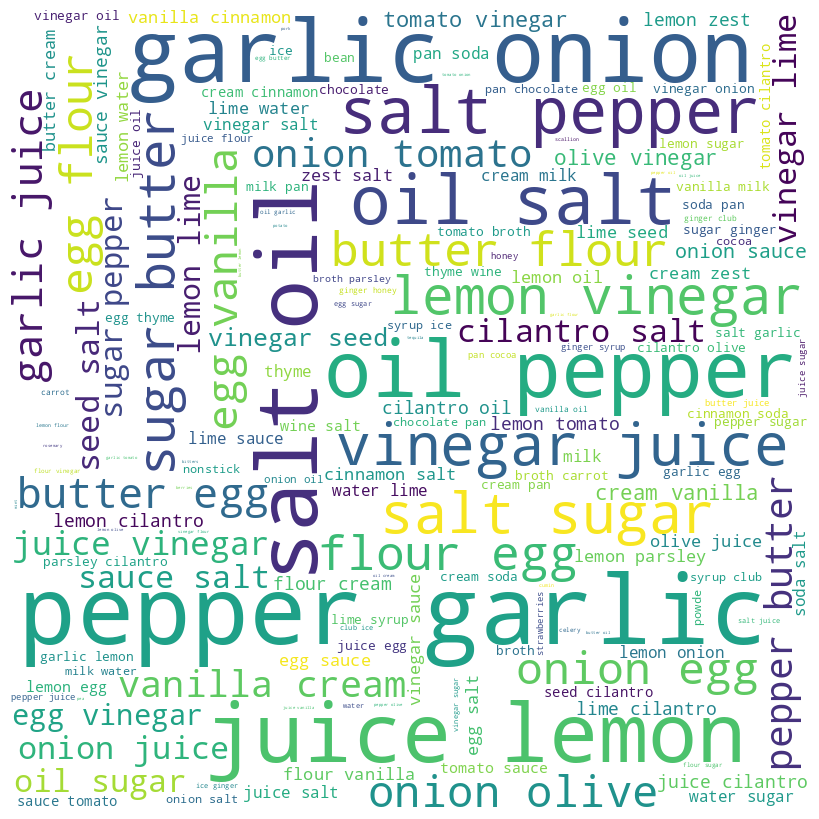

**************************************************
**************************************************
Model: Resnet18


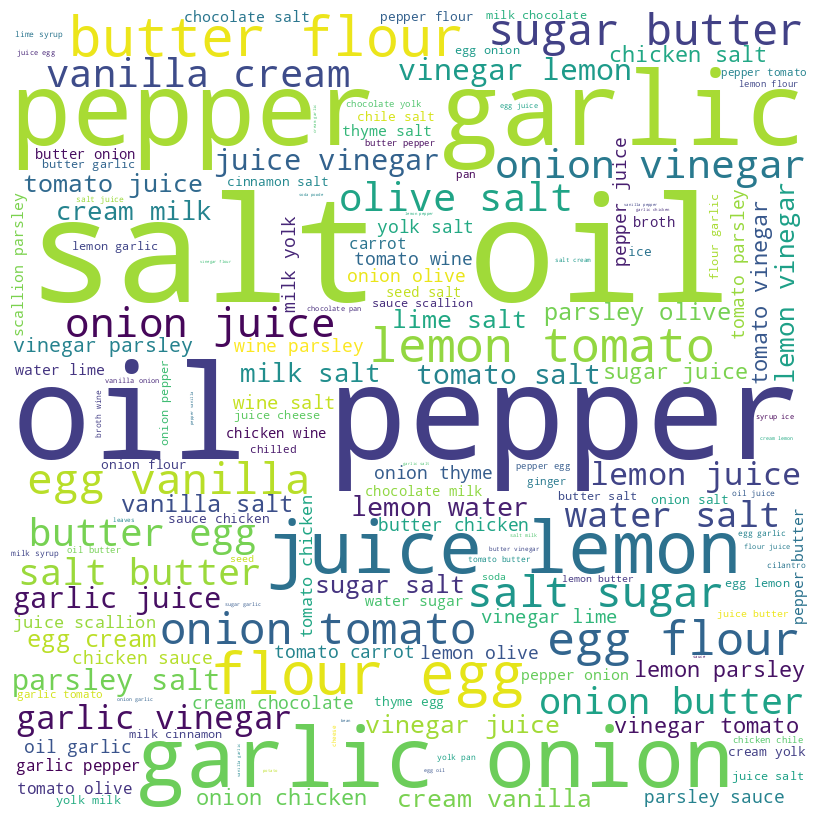

**************************************************
**************************************************
Model: Resnet101


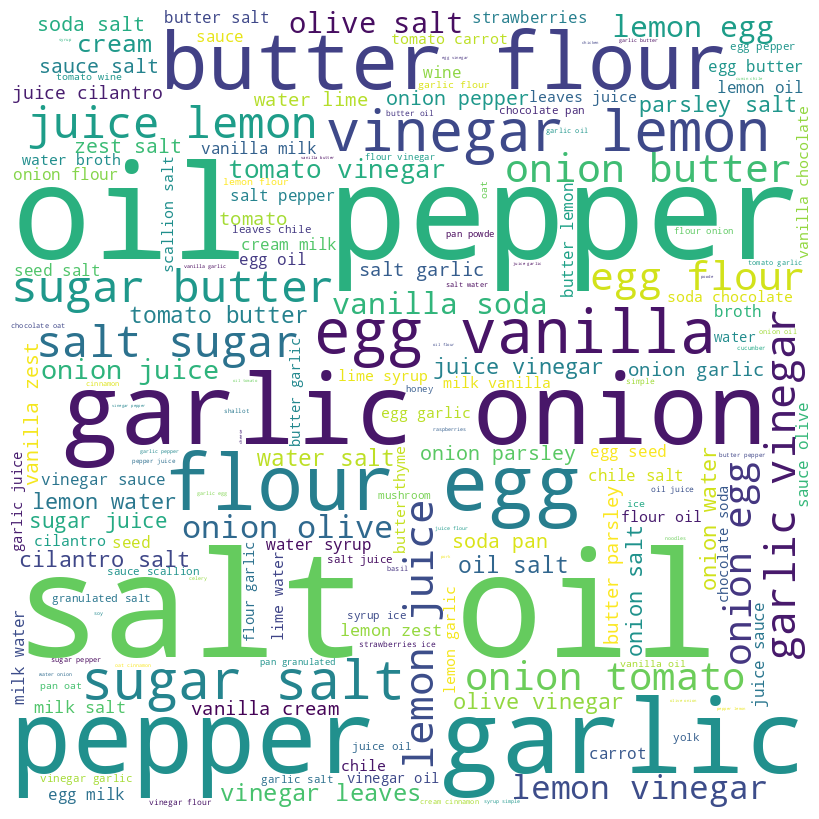

**************************************************
**************************************************
Model: Resnet152


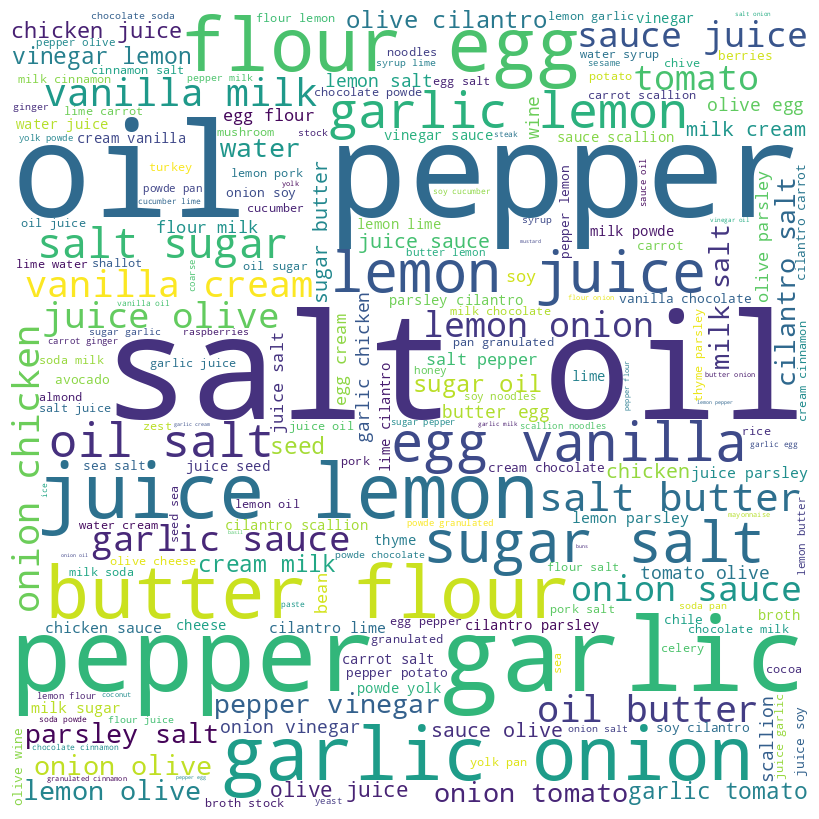

**************************************************
**************************************************
Model: Meta


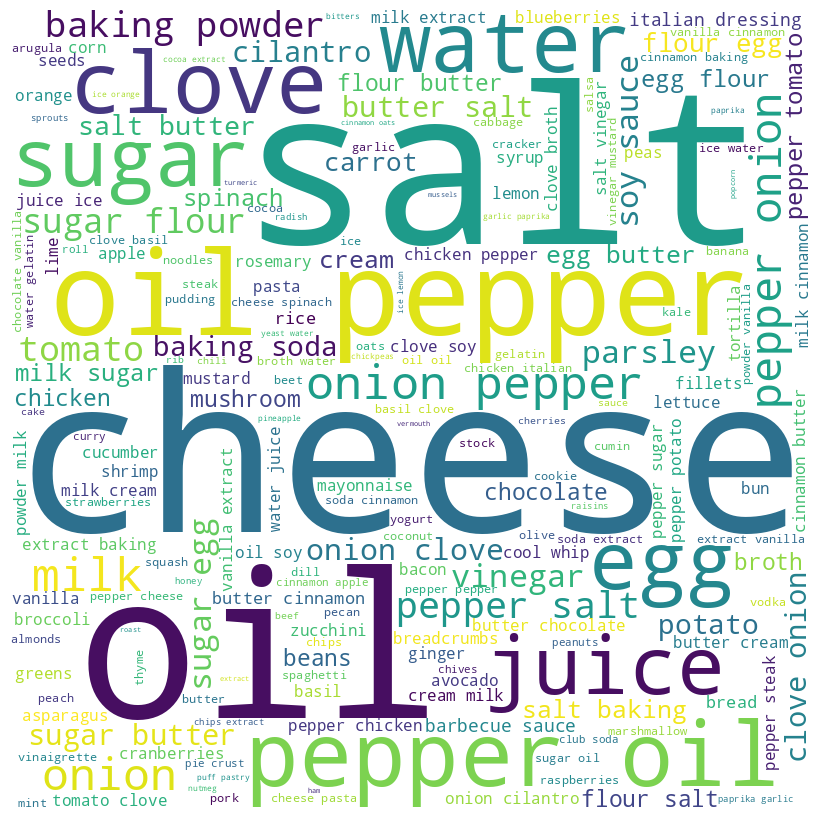

**************************************************


In [73]:
for model in pred_df_wordcloud["conv_model"].unique():
  text_title_true = ' '.join(pred_df_wordcloud[pred_df_wordcloud["conv_model"]==model]["ingrs"])
  text_title_true = text_title_true.replace("'","").replace(",","").replace("_"," ").replace("  "," ")
  wordcloud = WordCloud(width = 800, height = 800, background_color ='white').generate(text_title_true)
  plt.figure(figsize = (8, 8), facecolor = None)
  plt.imshow(wordcloud)
  plt.axis("off")
  plt.tight_layout(pad = 0)
  print("*"*50)
  print(f"Model: {model}")

  plt.savefig(f'../Kaggle data/predicted_ingrs_wordcloud_{model}.png')
  # Mostrar la nube de palabras
  plt.show()
  print("*"*50)